# Mobile Game A/B Testing

This project performs an A/B testing for a mobile game called Cookies Cat. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

In [24]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time/ make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

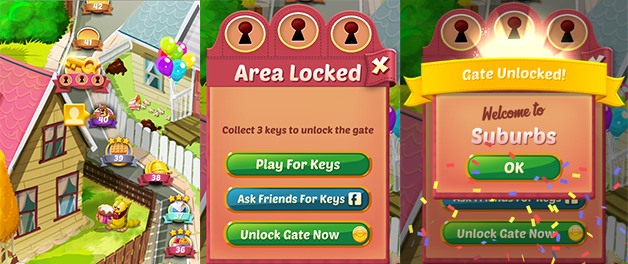

But where should the gates be placed? Initially the first gate was placed at level 30, but we're going to analyze an AB-test where we moved the first gate in the game from level 30 to level 40. For this A/B testing: <br>
- The business problem - how the gate placement affects player retention <br>
- The null hypothesis - changing the placement of the first gate from level 30 to 40 does not improve player retention <br>
- The focus - to assess the impact on player retention <br>
- The factor - the level placement of the first gate that forces players to wait a non-trivial amount of time/ make an in-app purchase to progress <br>
- The variant - level 30 (control), level 40 <br>
- The response variable - player retention

# Data Exploration

In [7]:
import pandas as pd
df = pd.read_csv('datasets/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:
- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

Upon game installation, the player was randomly assigned to either gate_30 or gate_40. 

## Sample Size

As a sanity check, the number of player in each AB group will be examined:

In [8]:
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

The number of players in each group is comparable.

In [31]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


## Distribution of Game Rounds

The number of players who played 0 to 100 game rounds during their first 2 weeks playing the game is examined:

Text(0, 0.5, 'userid')

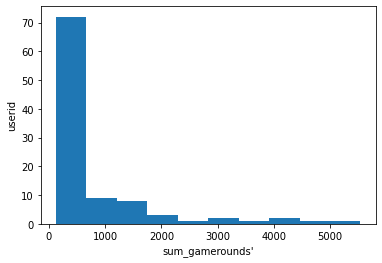

In [38]:
plot_df = df.groupby('sum_gamerounds')['userid'].count()
ax = plot_df.head(100).plot(x="sum_gamerounds", y="userid", kind="hist")
ax.set_xlabel("sum_gamerounds'")
ax.set_ylabel("userid")

In [40]:
print(plot_df.head(20))

sum_gamerounds
0     3994
1     5538
2     4606
3     3958
4     3629
5     2992
6     2861
7     2379
8     2267
9     2013
10    1752
11    1654
12    1570
13    1594
14    1519
15    1446
16    1342
17    1269
18    1228
19    1158
Name: userid, dtype: int64


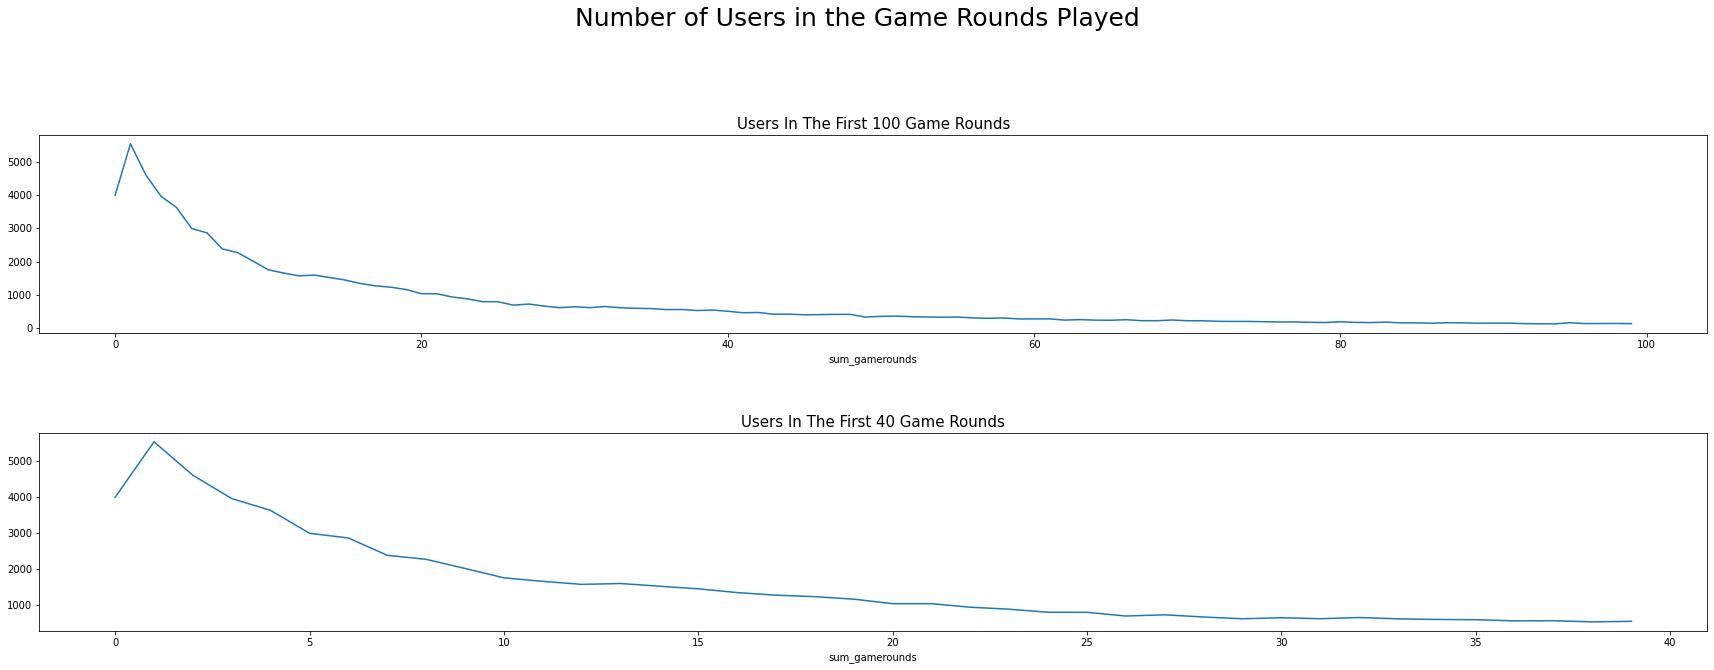

In [37]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
df.groupby("sum_gamerounds").userid.count()[:100].plot(ax = axes[0])
df.groupby("sum_gamerounds").userid.count()[:40].plot(ax = axes[1])
plt.suptitle("Number of Users in the Game Rounds Played", fontsize = 25)
axes[0].set_title("Users In The First 100 Game Rounds", fontsize = 15)
axes[1].set_title("Users In The First 40 Game Rounds", fontsize = 15)
plt.tight_layout(pad=5);

In the plot above, it's observed that: <br>
- Some players installed the game but then never played it (0 game rounds) <br>
- Some players just played a couple of game rounds in their first week <br>
- Some players played the game actively 

How many users reached level-30 and level-40 in the game?

In [41]:
plot_df.loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

## Retention Variables

In [43]:
pd.DataFrame({"ret1_count": df["retention_1"].value_counts(),
              "ret7_count": df["retention_7"].value_counts(),
              "ret1_%": df["retention_1"].value_counts()/ len(df),
              "ret7_%": df["retention_7"].value_counts()/ len(df)})

,ret1_count,ret7_count,ret1_%,ret7_%
False,50036,73408,0.55479,0.813935
True,40153,16781,0.44521,0.186065


Around 55 percent of the players didn't come back to play the game 1 day after the installation;<br>
Around 81 percent of the players didn't come back to play the game 7 days after the installation.

In [ ]:
The retention ratio can be further explored with the combination of the 2 AB-groups.

In [46]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean"])

count  median       mean
version retention_1                          
gate_30 False        24666     6.0  18.379591
        True         20034    48.0  94.411700
gate_40 False        25370     6.0  16.340402
        True         20119    49.0  95.381182

In [47]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean"])

count  median        mean
version retention_7                           
gate_30 False        36198    11.0   25.796508
        True          8502   105.0  165.962479
gate_40 False        37210    11.0   25.856356
        True          8279   111.0  165.649837

It's observed that the numbers of players who came back to play the game 1 day or 7 days after the installation are similar for both level-30 and -40.

In [49]:
df["Retention"] = np.where((df.retention_1==True) & (df.retention_7==True), 1,0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean"])

count  median        mean
version Retention                           
gate_30 0          38024    12.0   29.380654
        1           6676   127.0  183.886309
gate_40 0          38983    12.0   28.103353
        1           6506   133.0  190.282355

The numbers of players who came back to play the game both 1 day and 7 days after the installation are also similar for both level-30 and -40.

## KPI

## Overall 1-day Retention:

A common metric in the video gaming industry for how fun and engaging a game is 1-day retention - the percentage of players that comes back and plays the game 1 day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base. 

In [13]:
df['retention_1']==True
df['retention_1'].mean()

0.4452095044850259

Around 44% of players came back to the game 1 day after installing the game. This will serve as the benchmark that will in turn allows how the 1-day retention differs between the 2 AB-groups.

In [22]:
df.groupby('version')['retention_1'].sum()/ df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

It's observed that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control group when it was at level 30 (44.8%). <br><br> However, while it's certain that there is a difference, the certainty that a gate at level 40 will be worse for player retention in the future needs to be determined. 

### Bootstrap Analysis for the Difference in 1-day Retention between AB-groups

A bootstrapping with 500 bootstrap replications will be performed to determine the certainty of these retention numbers. In each replication, the dataset (with replacement) will be repeatedly re-sampled & the mean 1-day retention will be calculated for those samples for each AB-group.  <br><br>
The variation in 1-day retention will give an indication of how uncertain the retention numbers are. <br><br>
The number of bootstrap application is restricted to 500 due to resource constraint. 

<AxesSubplot:ylabel='Density'>

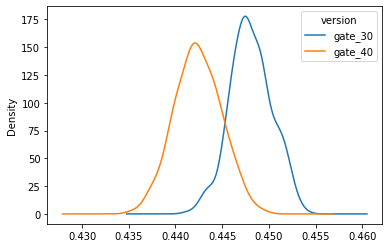

In [15]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
    
boot_1d.plot(kind='kde')

In the kernel density plot, these 2 distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the 2 AB-groups. From the plot, it's observed that there seems to be some evidence of a difference, albeit small. The difference in 1-day retention between groups is then examined.

Text(0.5, 0, '% difference in means')

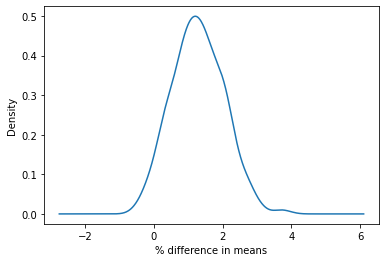

In [16]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40'])/ boot_1d['gate_40']*100)
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

It's observed from this chart that the most likely % difference in the mean between these 2 groups is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. The probability that the difference is above 0% is then investigated. 

In [17]:
prob = (boot_1d['diff'] > 0).sum()/ len(boot_1d)
'{:.1%}'.format(prob)

'96.2%'

There is a high probability of 96% that 1-day retention is better when the gate is at level 30. 

## Overall 7-day Retention:

However, since players have only been playing the game for 1 day, it is likely that most players haven't reached level 30 yet, so many players won't have been affected by the gate, even if it's as early as level 30. <br><br>
But after having played for a week, more players should have reached level 40, and therefore the 7-day retention will be examined as well - what percentage of the people that installed the game also showed up a week later to play the game again.

In [19]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

Like with 1-day retention, it's observed that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). 

This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention, so fewer people play a game 7 days after installing it than 1 day after installing.

A bootstrap analysis will be performed again to figure out how certain the difference of 7-day retention is between the AB-groups.

### Bootstrap Analysis for the Difference in 7-day Retention between AB-groups:

'99.6%'

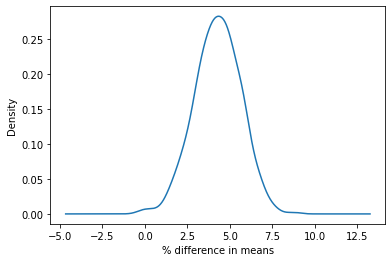

In [20]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40'])/ boot_7d['gate_30']*100)

ax = boot_7d['diff'].plot(kind='kde')
ax.set_xlabel("% difference in means")

prob = (boot_7d['diff'] > 0).sum()/ len(boot_7d)
'{:.1%}'.format(prob)

It's observed from the bootstrap result that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.

# Conclusion:

Hence, the conclusion is - if we want to keep retention high for both 1-day and 7-day retention, the gate should not be moved from level 30 to level 40. A guess is that when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it, and thus the lower retention rate.

# Suggestion for Future Implementation

Player retention was examined because it is one of the most important metrics - if the player base cannot be retained, it doesn't matter how much money they spend in-game. In the future, other metrics such as the number of game rounds played or how much in-game purchases are made by the 2 AB-groups. 